In [1]:
import numpy as np
#from ptychoSampling.reconstruction.recons import ReconstructionT
from ptychoSampling.reconstruction.forwardmodel_t import FarfieldForwardModelT
from ptychoSampling.reconstruction.wavefront_t import propFF_t, fftshift_t
from ptychoSampling.utils.utils import getRandomComplexArray
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from ptychoSampling.farfield.simulation import Simulation
import dill
from ptychoSampling.reconstruction.utils.utils import getComputationalCostInFlops
from skimage.feature import register_translation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
s = Simulation(poisson_noise=False)

In [4]:
obj_guess = deepcopy(s.obj)
obj_guess.array = getRandomComplexArray(s.obj.shape)

In [5]:
position_indices = np.random.permutation(s.intensities.shape[0])

In [272]:
tf.reset_default_graph()
fwd_model = FarfieldForwardModelT(obj=obj_guess, probe=s.probe, scan_grid=s.scan_grid)

position_indices_t = tf.placeholder(dtype=tf.int32, shape=(1,))
train_data_t = tf.reshape(tf.gather(s.intensities ** 0.5, position_indices_t), [-1])

obj_view_t = tf.gather(fwd_model._obj_views_all_t, position_indices_t)[0]

exit_wave_guess_t = fwd_model.probe_cmplx_t * fftshift_t(obj_view_t)
f1_t = propFF_t(exit_wave_guess_t)
f2_t = f1_t * tf.cast(tf.reshape(train_data_t, f1.shape)/ (tf.abs(f1_t) + 1e-10), "complex64")
exit_wave_new_t = propFF_t(f2_t, backward=True)
t1_t = tf.conj(fwd_model.probe_cmplx_t) / tf.cast(tf.reduce_max(tf.abs(fwd_model.probe_cmplx_t)**2), "complex64")
t2_t = exit_wave_new_t - exit_wave_guess_t
obj_view_new_t = fftshift_t(obj_view_t + t1_t * t2_t)

view_indices_t = tf.gather(fwd_model._obj_view_indices_t, position_indices_t)[0]
obj_w_border_new_t = tf.tensor_scatter_update(tf.reshape(fwd_model.obj_w_border_t, [-1]),
                                        tf.reshape(view_indices_t, [-1, 1]),
                                        tf.reshape(obj_view_new_t, [-1]))
obj_w_border_new_t = tf.reshape(obj_w_border_new_t, fwd_model.obj_w_border_t.shape)
(s1, s2), (s3, s4) = s.obj.border_shape
obj_cmplx_new_t = obj_w_border_new_t[s1: -s2, s3: -s4]

obj2_t = tf.reshape(obj_cmplx_new_t, [-1])
obj_vals_new_t = tf.concat((tf.real(obj2_t), tf.imag(obj2_t)), axis=0)
assign_op = fwd_model.obj_v.assign(obj_vals_new_t)

I1003 11:31:15.977658 140341857142592 forwardmodel_t.py:86] Creating obj views for the scan positions.


In [273]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [274]:
for i in range(10):
    for p in position_indices:
        session.run(assign_op, feed_dict={position_indices_t: [p]})
obj_array_new = session.run(fwd_model.obj_cmplx_t)

In [281]:
flops_count = getComputationalCostInFlops(tf.get_default_graph())

W1003 11:54:21.118638 140341857142592 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:14: The name tf.NodeDef is deprecated. Please use tf.compat.v1.NodeDef instead.

W1003 11:54:21.119449 140341857142592 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.

W1003 11:54:21.120096 140341857142592 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/utils/utils.py:33: The name tf.profiler.ProfileOptionBuilder is deprecated. Please use tf.compat.v1.profiler.ProfileOptionBuilder instead.

W1003 11:54:21.120625 140341857142592 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/utils/utils.py:34: The name tf.profiler.profile is deprecated. Please use tf.compat.v1.profiler.profile 

In [286]:
total_flops = flops_count * 300 * s.intensities.shape[0]
print(f"total_flops {total_flops:4.3g}")

total_flops 2.57e+11


In [9]:
obj_guess_new = deepcopy(obj_guess)
obj_guess_new_2 = deepcopy(obj_guess)

In [10]:
for i in range(10):
    for p in position_indices:
        ampl = s.intensities[p] ** 0.5

        py, px = s.scan_grid.positions_pix[p]
        

        obj_view = obj_guess_new.bordered_array[py: py + 64, px: px + 64]
        exit_wave_guess = s.probe.wavefront * np.fft.fftshift(obj_view)
        
        
        py, px = s.scan_grid.positions_pix[p]
        obj_view2 = obj_guess_new_2.bordered_array[py: py + 64, px: px + 64]

        exit_wave2 = np.fft.fftshift(obj_view2) * s.probe.wavefront
        
        
        

        f1 = exit_wave_guess.propFF()
        f2 = f1 * ampl / (np.abs(f1) + 1e-10)
        exit_wave_new = f2.propFF(backward=True)
        t1 = np.conj(s.probe.wavefront) / np.max(s.probe.wavefront.intensities)
        t2 = exit_wave_new - exit_wave_guess
        obj_view_new = obj_view + np.fft.ifftshift(t1 * t2)
        
        
                
        f12 = exit_wave2.propFF()
        f22 = f12 * s.intensities[p] ** 0.5  / (np.abs(f12) + 1e-10)
        #exit_wave_new = np.fft.ifft2(f2, norm='ortho')
        exit_wave_new2 = f22.propFF(backward=True)
        
        t12 = np.conj(s.probe.wavefront) / (np.max(np.abs(s.probe.wavefront)**2))
        t22 = exit_wave_new2 - exit_wave2
        obj_view_new2 = obj_view2 + np.fft.ifftshift(t12 * t22)
        
        
        
        
        bordered_array_new = obj_guess_new.bordered_array.copy()
        bordered_array_new[py: py + 64, px: px + 64] = obj_view_new

        (s1, s2), (s3, s4) = s.obj.border_shape
        obj_guess_new.array = bordered_array_new[s1:-s2, s3:-s4]
        
        
        
        obj_w_border_new2 = obj_guess_new_2.bordered_array.copy()
        obj_w_border_new2[py: py + 64, px: px + 64] = obj_view_new2
        (s1, s2), (s3, s4) = obj_guess_new_2.border_shape

        obj_guess_new_2.array = obj_w_border_new2[s1: -s2, s3: -s4]
        
        #print(np.abs(obj_view - obj_view2).sum(),
        #      np.abs(f1 - f12).sum(),
        #      np.abs(obj_guess_new.array - obj_guess_new_2.array).sum(), 
        #      np.abs(obj_view_new - obj_view_new2).sum())
    
    #print(register_translation(obj_guess_new_2.array, obj_guess_new.array))
    _, err1, phase = register_translation(s.obj.array, obj_guess_new.array)
    _, err1, phase = register_translation(s.obj.array, obj_guess_new.array * np.exp(1j * phase))
    
    _, err2, phase = register_translation(s.obj.array, obj_guess_new_2.array)
    _, err2, phase = register_translation(s.obj.array, obj_guess_new_2.array * np.exp(1j * phase))
    
    print(err1, err2)

0.721357268617339 0.721357268617339
0.6690823991627957 0.6690823991627957
0.6498718158224289 0.6498718158224289
0.6417209750480605 0.6417209750480605
0.638239395364428 0.638239395364428
0.6368542948704048 0.6368542948704048
0.6364488629294496 0.6364488629294496
0.6363439305701644 0.6363439305701644
0.6361816994575951 0.6361816994575951
0.6357625593229823 0.6357625593229823


In [8]:
for i in range(10):
    for p in position_indices:
        py, px = s.scan_grid.positions_pix[p]
        obj_view = obj_guess_new_2.bordered_array[py: py + 64, px: px + 64]

        exit_wave = np.fft.fftshift(obj_view) * s.probe.wavefront

        #f1 = np.fft.fft2(exit_wave, norm="ortho")
        f1 = exit_wave.propFF()
        f2 = f1 * s.intensities[p] ** 0.5  / (np.abs(f1) + 1e-10)
        #exit_wave_new = np.fft.ifft2(f2, norm='ortho')
        exit_wave_new = f2.propFF(backward=True)
        
        t1 = np.conj(s.probe.wavefront) / (np.max(np.abs(s.probe.wavefront)**2))
        t2 = exit_wave_new - exit_wave
        obj_view_new = obj_view + np.fft.ifftshift(t1 * t2)

        obj_w_border_new = obj_guess_new_2.bordered_array.copy()
        obj_w_border_new[py: py + 64, px: px + 64] = obj_view_new
        (s1, s2), (s3, s4) = obj_guess_new_2.border_shape

        obj_guess_new_2.array = obj_w_border_new[s1: -s2, s3: -s4]
    print(register_translation(s.obj.array, obj_guess_new_2.array))

(array([0., 0.]), 0.7213572686173388, -1.5222992740086427)
(array([0., 0.]), 0.6690823991627955, -1.4686010145410362)
(array([0., 0.]), 0.6498718158224288, -1.4275759027824164)
(array([0., 0.]), 0.6417209750480604, -1.391915023551239)
(array([0., 0.]), 0.6382393953644282, -1.3592618305638602)
(array([0., 0.]), 0.6368542948704048, -1.3286340785368074)
(array([0., 0.]), 0.6364488629294495, -1.299703334443887)
(array([0., 0.]), 0.6363439305701641, -1.2723070803227599)
(array([0., 0.]), 0.6361816994575952, -1.2461894694184048)
(array([0., 0.]), 0.6357625593229825, -1.221322597437943)


In [11]:
np.abs(obj_guess_new_2.array - obj_guess_new.array).sum()

0.0

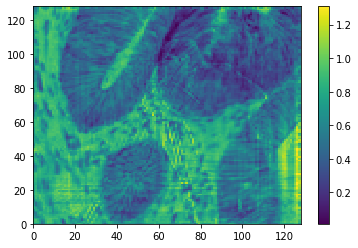

In [12]:
plt.pcolormesh(np.abs(obj_guess_new.array))
plt.colorbar()
plt.show()

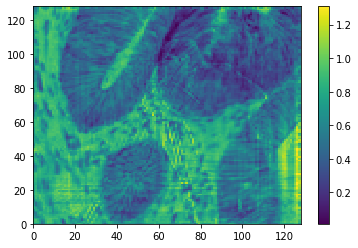

In [13]:
plt.pcolormesh(np.abs(obj_guess_new_2.array))
plt.colorbar()
plt.show()

In [16]:
from ptychoSampling.reconstruction.wavefront_t import propFF_t

In [19]:
f12 = f1.astype('complex64')

In [26]:
f12b = np.fft.ifft2(f12, norm='ortho')

In [22]:
f12c = propFF_t(tf.constant(f12, dtype="complex64"), backward=True)

W1006 17:45:26.209576 139881707538240 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/wavefront_t.py:103: The name tf.ifft2d is deprecated. Please use tf.signal.ifft2d instead.



In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [24]:
f12co = sess.run(f12c)

In [27]:
f12co - f12b

array([[ 0.0000000e+00+2.3841858e-07j,  0.0000000e+00+0.0000000e+00j,
        -9.5367432e-07+2.3841858e-07j, ...,
        -4.7683716e-06+1.9073486e-06j, -4.7683716e-06+2.3841858e-06j,
        -4.7683716e-06+2.3841858e-06j],
       [ 0.0000000e+00-3.5762787e-07j, -4.7683716e-07+1.1920929e-07j,
        -9.5367432e-07+0.0000000e+00j, ...,
        -4.2915344e-06+1.6689301e-06j, -4.7683716e-06+1.9073486e-06j,
        -5.7220459e-06+3.3378601e-06j],
       [-4.7683716e-07-2.3841858e-07j, -9.5367432e-07+0.0000000e+00j,
        -7.1525574e-07+0.0000000e+00j, ...,
        -3.8146973e-06+9.5367432e-07j, -4.2915344e-06+9.5367432e-07j,
        -3.3378601e-06+1.1920929e-06j],
       ...,
       [-1.9073486e-06+1.0728836e-06j, -1.9073486e-06+1.6093254e-06j,
        -1.9073486e-06+7.1525574e-07j, ...,
        -3.5762787e-06+1.7881393e-06j, -5.2452087e-06+2.6226044e-06j,
        -7.1525574e-06+3.9339066e-06j],
       [-3.8146973e-06+1.6689301e-06j, -3.8146973e-06+1.4305115e-06j,
        -2.1457672e-06

In [86]:
arr1 = np.concatenate((np.real(s.obj.array.flat), np.imag(s.obj.array.flat)))
arr2 = np.reshape([np.real(s.obj.array), np.imag(s.obj.array)], [-1])
arr3 = np.

In [90]:
np.abs(arr1 - arr2).sum()

0.0

In [87]:
arr2

array([0.7977362 , 0.7952584 , 0.74141514, ..., 0.2048352 , 0.18401843,
       0.17746323], dtype=float32)

In [33]:
obj_new = obj_view_new[]

W1002 16:01:07.063485 140341857142592 deprecation_wrapper.py:119] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/IPython/core/interactiveshell.py:1733: The name tf.tensor_scatter_update is deprecated. Please use tf.tensor_scatter_nd_update instead.



Signature: tf.tensor_scatter_update(tensor, indices, updates, name=None)
Source:   
@_dispatch.add_dispatch_list
@tf_export('tensor_scatter_nd_update', v1=['tensor_scatter_nd_update', 'tensor_scatter_update'])
@deprecated_endpoints('tensor_scatter_update')
def tensor_scatter_update(tensor, indices, updates, name=None):
  r"""Scatter `updates` into an existing tensor according to `indices`.

  This operation creates a new tensor by applying sparse `updates` to the passed
  in `tensor`.
  This operation is very similar to `tf.scatter_nd`, except that the updates are
  scattered onto an existing tensor (as opposed to a zero-tensor). If the memory
  for the existing tensor cannot be re-used, a copy is made and updated.

  If `indices` contains duplicates, then their updates are accumulated (summed).

  **WARNING**: The order in which updates are applied is nondeterministic, so the
  output will be nondeterministic if `indices` contains duplicates -- because
  of some numerical approximatio

In [ ]:
try:
    with open('mabp/obj.pkl', 'rb') as f:
        obj = dill.load(f)
    with open('mabp/probe_3d.pkl', 'rb') as f:
        probe_3d = dill.load(f)
    with open('mabp/scan_grid_filtered.pkl', 'rb') as f:
        scan_grid = dill.load(f)
    with open('mabp/detector.pkl', 'rb') as f:
        detector = dill.load(f)
    with open('mabp/intensities_filtered.pkl', 'rb') as f:
        intensities = dill.load(f)
except:
    s = Simulation()
    obj = deepcopy(s.obj)
    probe_3d = deepcopy(s.probe_3d)
    detector = deepcopy(s.detector)
    scan_grid_filtered, intensities_filtered = s.filterScanPositionsAndIntensities()
    
    names_items = {'obj':obj, 
                   'probe_3d':probe_3d, 
                   'scan_grid_filtered':scan_grid_filtered,
                   'detector':detector,
                   'intensities_filtered': intensities_filtered,
                   'simulation': s}
    for n, item in names_items.items():
        with open(f'mabp/{n}.pkl', 'wb') as f:
            dill.dump(item, f)

In [ ]:
if 0:
    with open('mabp/simulation.pkl', 'rb') as f:
        s = dill.load(f)
else:
    s = Simulation(obj=obj, detector=detector, poisson_noise=False)

In [5]:
obj_guess = deepcopy(s.obj)
obj_guess.array = getRandomComplexArray(shape=obj_guess.array.shape, phase_range=2*np.pi)

In [6]:
r = ReconstructionT(obj = obj_guess, 
                    probe=s.probe_3d,
                    grid=grid_new,
                    intensities=intensities_new,
                    batch_size=100,
                    n_validation=50)

I0924 14:43:29.119124 140473724618560 recons.py:36] creating batches...
W0924 14:43:29.620115 140473724618560 deprecation.py:323] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:225: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
I0924 14:43:29.706339 140473724618560 recons.py:39] creating log...


In [7]:
r.attachForwardModel("bragg")

I0924 14:43:30.481296 140473724618560 forwardmodel_t.py:28] Creating obj views for the scan positions.
I0924 14:43:35.662797 140473724618560 forwardmodel_t.py:224] Creating the phase modulations for the scan angles.


In [8]:
r.attachLossFunction("least_squared")

W0924 14:43:38.718116 140473724618560 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/wavefront_t.py:98: The name tf.fft2d is deprecated. Please use tf.signal.fft2d instead.



In [9]:
r.attachOptimizerPerVariable("obj", optimizer_type="adam", optimizer_args = {"learning_rate":1e-2})

W0924 14:43:38.796485 140473724618560 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/optimization.py:11: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0924 14:43:38.927090 140473724618560 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
r.addCustomMetricToDataLog("obj_error", r.fwd_model.obj_cmplx_t, 10, s.obj.array)

In [11]:
r.finalizeSetup()

I0924 14:43:39.210630 140473724618560 recons.py:243] finalizing the data logger.
I0924 14:43:39.211238 140473724618560 datalogs_t.py:101] Initializing the log outputs...
W0924 14:43:39.217918 140473724618560 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:246: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

I0924 14:43:39.218586 140473724618560 recons.py:248] Initializing the session.
W0924 14:43:39.219084 140473724618560 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:249: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0924 14:43:39.325948 140473724618560 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:250: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instea

In [13]:
r.run(10000)

          epoch  train_loss  validation_loss  validation_min   patience  obj_error
1001         35    9.25e+03            7e+03           7e+03         50      0.803
1281         45   7.51e+03   4.85e+03   4.85e+03         50       0.78
1561         55   4.66e+03   3.93e+03   3.93e+03         50      0.761
1841         65   4.62e+03   3.23e+03   3.23e+03         50      0.752
2121         75   3.78e+03   2.63e+03   2.63e+03         60       0.74
2401         85    3.9e+03   2.25e+03   2.25e+03         75      0.733
2681         95   2.13e+03   1.64e+03   1.64e+03         90      0.728
2961        105   2.18e+03   1.38e+03   1.38e+03        105      0.725
3241        115   1.56e+03   1.18e+03   1.18e+03        120      0.717
3521        125   2.01e+03   1.04e+03   1.04e+03        135      0.699
3801        135   1.63e+03        919        906        148      0.681
4081        145   1.36e+03        852        852        165      0.667
4361        155   1.35e+03        832        832     

In [14]:
from ptychoSampling.utils.register_translation_3d import register_translation_3d

In [15]:
register_translation_3d(r.obj.array * np.exp(-1j * 2.12), s.obj.array, upsample_factor=10)

(array([ 0.,  0., -0.]), 0.6485759689970292, 2.8931046629598227)

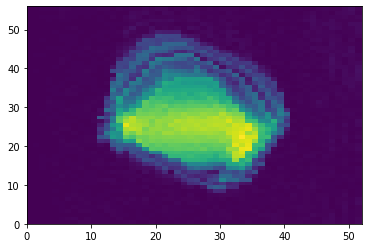

In [16]:
plt.pcolormesh(np.abs(r.obj.array[11]))

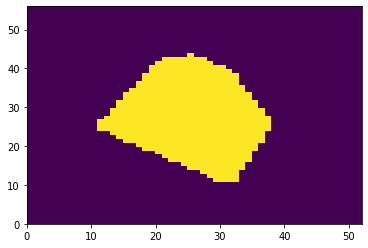

In [17]:
plt.pcolormesh(np.abs(s.obj.array[10]))

In [23]:
s.obj.array.shape

(46, 58, 70)

In [24]:
r.obj.array.shape

(46, 58, 70)

In [45]:
np.abs(s.obj.array[42,:,:]).sum()

9.0

In [36]:
a1 = np.arange(36).reshape(6,6)
shape = (4, 4)

In [23]:
a2 = a1[2:5, 2:5]

In [24]:
a2

array([[14, 15, 16],
       [20, 21, 22],
       [26, 27, 28]])

In [25]:
a2[2:4] = 0

In [26]:
a1

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25,  0,  0,  0, 29],
       [30, 31, 32, 33, 34, 35]])

In [31]:
mask = np.full(a1.shape, True)
mask[1:5, 1:5] = False

In [32]:
mask

array([[ True,  True,  True,  True,  True,  True],
       [ True, False, False, False, False,  True],
       [ True, False, False, False, False,  True],
       [ True, False, False, False, False,  True],
       [ True, False, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True]])

In [33]:
a1[mask] = 1

In [34]:
a1

array([[ 1,  1,  1,  1,  1,  1],
       [ 1,  7,  8,  9, 10,  1],
       [ 1, 13, 14, 15, 16,  1],
       [ 1, 19, 20, 21, 22,  1],
       [ 1, 25,  0,  0,  0,  1],
       [ 1,  1,  1,  1,  1,  1]])

In [38]:
a1[~mask].reshape(shape)

array([[ 7,  8,  9, 10],
       [13, 14, 15, 16],
       [19, 20, 21, 22],
       [25, 26, 27, 28]])

In [39]:
a1[~mask] = 10

In [40]:
a1

array([[ 0,  1,  2,  3,  4,  5],
       [ 6, 10, 10, 10, 10, 11],
       [12, 10, 10, 10, 10, 17],
       [18, 10, 10, 10, 10, 23],
       [24, 10, 10, 10, 10, 29],
       [30, 31, 32, 33, 34, 35]])

In [33]:
import numpy as np
from typing import Tuple, List, Union, Any, Optional
import abc
import scipy, scipy.stats
import skimage, skimage.data, skimage.transform
from ptychoSampling.logger import logger
import ptychoSampling.utils

class Obj(abc.ABC):
    """
    Parameters
    ----------
    shape : Tuple(int, int)
        Number of pixels in each axis of the sample
    border_shape : array_like
        Number of pixels to add along the border in the left, right, top, and bottom margins of the sample. If
        ``border_npix = 10``, then the simulation adds 10 pixels to the left of the sample, and 10 pixels to the
        right of the sample, i.e. a total of 20 pixels along the x-direction (and similarly with y). Defaults to ``0``.
        The provided value needs to be compatible with the `pad` argument for `numpy.pad`.
    border_const : complex
        Constant value to fill the border with. Defaults to ``0``.
    mod_range : float
        Maximum value of the modulus for the sample pixels.
    phase_range : float
        Maximum value of the phase for the sample pixels.
    pixel_size : tuple(float)
        Pixel size at the sample plane (assuming square pixels).

    Attributes
    ----------
    shape, border_shape, border_const, mod_range, phase_range : see Parameters
    array : ndarray(complex64)
        Transmission function for the sample/sample. Shape as defined by the `shape` parameter.
    bordered_array : ndarray(complex64)
        Transmission function for the sample plus the specified border.

    Notes
    -----
    Problematically, in blind ptychography experiments we encounter the *affine phase ambiguity*, i.e. a phase
    gradient (or phase ramp) in both the probe and the sample phases. To avoid this ambiguity, we can add a *known*
    border to the sample (a tight support), and fill the border with ones (i.e,. assume the border is transparent).
    This is the *bright-field boundary condition* that Albert Fannjiang talks about in [1]_ (also refer to other
    works by Fannjiang - [2]_ and [3]_).

    Thus, to avoid the affine phase ambiguity, we assume that the sample support is *priorly known*, i.e. we impose
    a *tight support*. If we do not remove the affine phase ambiguity this way, then we have to remove the phase
    ramp post-reconstruction, which is more difficult and error-prone.

    For the far-field ptychography simulations, by adding this border, we can additionally ensure overlapping probe
    coverage through the entirety of the sample (including the edges).

    We cannot use this approach for the Bragg ptychography case---while we get transmission through empty
    space, we do not get diffraction (at the Bragg angle) through empty space. As such, the bright field boundary
    condition does not apply.

    References
    ----------
    .. [1] Fannjiang, A. & Zhang, Z. Blind Ptychography by Douglas-Rachford Splitting. 1–21 (2018)
        (http://arxiv.org/abs/1809.00962).
    .. [2] Fannjiang, A. & Chen, P. Blind Ptychography: Uniqueness and Ambiguities. 1–29 (2018)
        (http://arxiv.org/abs/1806.02674).
    .. [3] Fannjiang, A. Raster Grid Pathology and the Cure. Multiscale Modeling & Simulation, 17(3), 973-995 (2019).
    """
    def __init__(self, shape: Tuple[int, ...],
                 border_shape: Tuple[Tuple[int,int], ...] = 0,
                 border_const: complex = 0,
                 mod_range: float = None,
                 phase_range: float = None,
                 pixel_size: Tuple[float,...] = None) -> None:
        self.shape = shape
        self.mod_range = mod_range
        self.phase_range = phase_range
        self.pixel_size = pixel_size
        self.border_const = border_const
        self._border_shape = border_shape

        self._setObjArrayValues()

    def _setObjArrayValues(self, values: Optional[np.ndarray] = None) -> None:
        """Set the obj transmission function and add the border.

        Performs sanity checks for the 'shape' and '_border_shape' parameters supplied when the class is created. The
        'shape' parameter should be tuple-like and composed of integers, formatted so that 'numpy.zeros' accepts it
        as an argument for the 'shape' parameter. The '_border_shape' should be formatted so that 'numpy.pad' accepts it
        as an argument for the 'pad' parameter.

        Sets the values for the 'array' and 'bordered_array' attributes.
        Parameters
        ----------
        values : array_like, optional
            Obj array values. For the default value 'None', the function creates an array of zeros.
        """

        if values is None:
            try:
                values = np.zeros(self.shape)
            except Exception as e:
                e2 = ValueError("Error in input obj shape.")
                logger.error([e, e2])
                raise e2 from e
                
        try:
            self.bordered_array = np.pad(values,
                                         self._border_shape,
                                         mode='constant',
                                         constant_values=self.border_const)
        except Exception as e:
            e2 = ValueError("Error in border specifications.")
            logger.error([e, e2])
            raise e2 from e
        
        self._border_mask = np.pad(np.full(self.shape, True),
                                   self._border_shape,
                                   mode="constant",
                                   constant_values=False)
        self.array = self.bordered_array[self._border_mask].reshape(self.shape)
        

    #@property
    #def array(self):
    #    return self.bordered_array[self._border_mask].reshape(self.shape)
    #    #return self._array

    #@array.setter
    #def array(self, array):
    #    self._setObjArrayValues(array)

    @property
    def border_shape(self):
        return self._border_shape

    @border_shape.setter
    def border_shape(self, border_shape):
        values = self.array.copy()
        self._border_shape = border_shape
        self._setObjArrayValues(values)


class CustomObjFromArray(Obj):
    r"""Create a `Obj` using a supplied array of values..

    See documentation for `Obj` for information on the attributes.

    Parameters
    ----------
    array: array_like(complex)
        Array that contains the obj values.
    border_shape, border_const, pixel_size : see documentation for `Obj`.

    See also
    --------
    Probe
    """

    def __init__(self, array: np.ndarray,
                 border_shape: Any = 0,
                 border_const: complex = 0,
                 pixel_size: Tuple[float, ...] = None) -> None:
        shape = array.shape
        super().__init__(shape, border_shape, border_const, pixel_size=pixel_size)
        self._setObjArrayValues(array.copy())


class Simulated2DObj(Obj):
    r"""Creates a sample complex-valued obj using stock  data from the skimage library.

    Uses the stock camera image for the phase and the stock immunohistochemistry  image (channel 0) for the
    modulus [4]_.

    See documentation for `Obj` for information on the attributes.

    Parameters
    ----------
    shape : Tuple[int, int]
        Shape of 2d obj array. Default is (128, 128).
    border_shape : array_like
        Default value adds a border of 32 pixels each on the top, bottom, left, and right of the obj array. See
        documentation of `Obj` for information on the border shape.
    border_const : complex
        Default value is 1.0, which corresponds to free space propagation . See documentation of `Obj` for more
        information.
    mod_range : float
        Default value is 1.0. This covers the entire gamut from opaque (0.0) to free space (1.0) propagation.
    phase_range : float
        Default value is :math:`\pi`.

    See also
    --------
    Obj

    References
    ----------
    .. [4] https://scikit-image.org/docs/dev/api/skimage.data.html
    """
    def __init__(self, shape=(128, 128),
                 border_shape=((32, 32), (32, 32)),
                 border_const=1.0,
                 mod_range=1.0,
                 phase_range=np.pi):
        if len(shape) != 2:
            e = ValueError('Supplied shape is not 2d.')
            logger.error(e)
            raise e
        super().__init__(shape, border_shape, border_const, mod_range, phase_range)
        self._createObj()

    def _createObj(self) -> None:
        """Create the obj array using data from skimage, then set the absolute value and phases using the
        specified ranges.
        """
        phase_img = skimage.img_as_float(skimage.data.camera())[::-1, ::-1]
        mod_img = skimage.img_as_float(skimage.data.immunohistochemistry()[:, :, 0])[::-1, ::-1]
        mod = skimage.transform.resize(mod_img, self.shape,
                                       mode='wrap', preserve_range=True)
        phase = skimage.transform.resize(phase_img, self.shape,
                                         mode='wrap', preserve_range=True)

        # Setting the ranges
        phase = (phase - np.min(phase)) / (np.max(phase) - np.min(phase)) * self.phase_range
        mod = (mod - np.min(mod)) / (np.max(mod) - np.min(mod)) * self.mod_range

        # Centering the phase at 0.
        phase = np.angle(np.exp(1j * (phase - scipy.stats.circmean(phase))))
        obj = (mod * np.exp(1j * phase)).astype('complex64')
        self._setObjArrayValues(obj)


class Simulated3DCrystalCell(Obj):
    r"""Creates a sample complex-valued crystal cell.

    The output is non-deterministic.

    Parameters
    ----------
    mesh_shape : Tuple[int, int, int]
        Number of points to use for the Delauney mesh generation. Note that this is **NOT** the shape of the final
        generated crystal cell. The final shape is non-deterministic.
    border_shape : array_like
        Default value adds a border of 32 pixels each on the top, bottom, left, and right of the obj array. See
        documentation of `Obj` for information on the border shape.
    border_const : complex
        Default value is 1.0, which corresponds to free space propagation . See documentation of `Obj` for more
        information.

    See also
    --------
    Obj
    utils.generateCrystalCell3D

    Notes
    -----
    * Since the crystal cell is generated randomly at each call of `utils.generateCrystalCell3D`, the output is not
        deterministic.
    * Based on conversations with Marc Allain ( I might have misinterpreted him...), for Bragg ptychography:
        - the border shape should be set so that the sample support is restricted along the line perpendicular to the
            exit wave direction (in the plane  that contains the rocking curve). I think that applying a *known* border
            such that the number of pixels here is :math:`>2\times` the support (or reconstruction
            variable) size in this direction should provide sufficient oversampling.
        - For ptychography, in the probe translation plane, we generally want the object array size to be
            :math:`>2\times` the size of the probe

    """
    def __init__(self, mesh_shape: Tuple[int, int, int] = (128, 128, 128),
                 border_shape=((0,0), (0,0), (0,0)),
                 border_const=0.0,
                 pixel_size=None):
        if len(mesh_shape) != 3:
            e = ValueError('Supplied shape is not 3d.')
            logger.error(e)
            raise e

        self.border_const = border_const
        self._border_shape = border_shape
        self.pixel_size = pixel_size

        self.mod_range = None
        self.phase_range = None

        self._createObj()
        self.shape = self.array.shape

    def _createObj(self) -> None:

        from ptychoSampling.utils.generateCrystalCell3D import generateCrystalCell, trimAndPadCell
        cell = generateCrystalCell(x_points=128, y_points=128, z_points=128)
        cell = trimAndPadCell(cell)
        self._setObjArrayValues(cell)


In [99]:
o2d = Simulated2DObj(shape=(5, 5), border_shape=((1, 1), (1, 1)))

In [100]:
array_slices = tuple([slice(b[0], -b[1]) for b in o2d.border_shape])

In [101]:
array_new = o2d.bordered_array[array_slices]

In [102]:
array_new = 5

In [107]:
shape = (5, 5, 5)

In [109]:
tuple((0, 0) for i in range(len(shape)))

((0, 0), (0, 0), (0, 0))

In [69]:
o2d.bordered_array += 10

In [89]:
array_new[2:3] = 1000

In [90]:
o2d.bordered_array

array([[   1.      +0.j        ,    1.      +0.j        ,
           1.      +0.j        ,    1.      +0.j        ,
           1.      +0.j        ,    1.      +0.j        ,
           1.      +0.j        ],
       [   1.      +0.j        ,   10.998984+0.04505691j,
          10.576295+0.09464422j,   10.64214 +0.07482475j,
          10.355867-0.4913203j ,   10.613377-0.33834833j,
           1.      +0.j        ],
       [   1.      +0.j        ,   10.991077-0.01158942j,
          10.636133-0.04613522j,   10.664955-0.31593272j,
           9.685742-0.7043967j ,   10.448448-0.68287885j,
           1.      +0.j        ],
       [   1.      +0.j        , 1000.      +0.j        ,
        1000.      +0.j        , 1000.      +0.j        ,
        1000.      +0.j        , 1000.      +0.j        ,
           1.      +0.j        ],
       [   1.      +0.j        ,   10.341619+0.38545495j,
          10.291846+0.28979668j,   10.163595-0.13935146j,
          10.      +0.j        ,   10.124393+0.07868

In [26]:
np.s_

In [28]:
np.index_exp[2:4, 4:6]

(slice(2, 4, None), slice(4, 6, None))

In [38]:
array_slices = tuple([slice(b1,-b2) for (b1, b2) in o2d.border_shape])

In [39]:
array_slices

(slice(10, -10, None), slice(10, -10, None))

In [40]:
np.arange(-1, 1, 6j)

array([], dtype=complex128)

In [43]:
np.r_[-1:1:6j]

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [44]:
arr = np.arange(10)

In [45]:
arr.strides

(8,)

In [46]:
arr.shape

(10,)

In [47]:
arr.strides

(8,)

In [48]:
a = np.array([1,5,1,2,5,7,8,2,4,1,5,6,7])

In [49]:
a

array([1, 5, 1, 2, 5, 7, 8, 2, 4, 1, 5, 6, 7])

In [50]:
b, inverse = np.unique(a, return_inverse=True)

In [52]:
b, inverse

(array([1, 2, 4, 5, 6, 7, 8]), array([0, 3, 0, 1, 3, 5, 6, 1, 2, 0, 3, 4, 5]))

In [56]:
b[inverse]

array([1, 5, 1, 2, 5, 7, 8, 2, 4, 1, 5, 6, 7])

array([1, 2, 1, 5, 2, 7, 8, 5, 1, 1, 2, 5, 7])

In [58]:
b_new = np.arange(b.shape[0])

In [59]:
b_new

array([0, 1, 2, 3, 4, 5, 6])

In [60]:
b_new[inverse]

array([0, 3, 0, 1, 3, 5, 6, 1, 2, 0, 3, 4, 5])